### In this Notebook we are able to download several days of MUR data and merge it into a single NetCDF file. Then we will import that NetCDF as an xarray. We can then apply the 3 algorithms (Canny, BOA and CCA), obtaining a Frontal Probability map for each algorithm, visualise and save the results in a folder called MUR_seasonal_images

#### WARNING: The CCA algorithm might take a lot of time to run depending on the period (number of days of data)

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import os
import cv2
import matplotlib
from matplotlib.colors import ListedColormap
from scipy.ndimage import gaussian_filter
import time
import sys
import wget
from math import floor
from pydap.client import open_url
from tqdm import tqdm
import sys
import netCDF4 as nc
import glob

import warnings
warnings.filterwarnings("ignore")

plt.rcParams["figure.figsize"] = 12, 10

/home/luisfigueiredo/.local/lib/python3.8/site-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (4.0.0) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


### Import functions to apply the BOA and CCA, which are defined in other notebooks

In [2]:
#import functions to aplly the Belkin O'Reilly Algorithm
from ipynb.fs.full.BOA_functions import boa

In [3]:
#import functions to aplly the Cayula-Cornillon Algorithm
from ipynb.fs.full.CCA_functions_xarray import getFrontInWindow
from ipynb.fs.full.CCA_functions_xarray import CCA_SIED

## ------------------------------- Function to Download MUR data (OUTDATED) --------------------------

In [4]:
def boundingindex(dmin, dint, boundary0, boundary1):
    """
    get boundaries values to download the data already cropped
    """
    inx0 = max(int(floor((boundary0 - dmin) / dint)), 0)
    inx1 = max(int(floor((boundary1 - dmin) / dint)), 0)
    if inx0 > inx1:
        atemp = inx0
        inx0 = inx1
        inx1 = atemp
    return [inx0, inx1]

In [5]:
def get_mur_params(lon_box, lat_box):
    """
    Check sample file to get parameters for sst
    """
    mur_ncin = open_url(
        'https://podaac-opendap.jpl.nasa.gov/opendap/allData/ghrsst/data/GDS2/L4/GLOB/JPL/MUR/v4.1/2018/002/20180102090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc')
    lon = mur_ncin['lon']
    lat = mur_ncin['lat']
    lon_step = np.mean(np.diff(lon))
    lat_step = np.mean(np.diff(lat))
    [mur_i0, mur_i1] = boundingindex(lon[0][0].data, lon_step, lon_box[0], lon_box[1])
    [mur_j0, mur_j1] = boundingindex(lat[0][0].data, lat_step, lat_box[0], lat_box[1])

    return mur_i0, mur_i1, mur_j0, mur_j1

In [6]:
def download_from_url(fileget, filenameout, replace, printiti):
    """
    function that tries to download data from "fileget" if the data didn't previously exist,
    the user asked to replace the old data, or the file has 0 bytes
    """
    exists = os.path.exists(filenameout)
    if exists:
        file_size = os.path.getsize(filenameout)
    else:
        file_size = 1
    if (not exists) or (replace and exists) or (file_size == 0):
        if exists:
            os.remove(filenameout)
        try:
            return wget.download(fileget, out=filenameout, bar=None)
        except Exception as e:
            if printiti:
                print(e)
                print("Error downloading")
                print("Download error url: " + fileget)
            return e
    return filenameout

In [7]:
def download_sst(path, date, mur_j0, mur_j1, mur_i0, mur_i1, replace):
    
    """
    Function to download a specific day of data. We need to provide 
    the path where it will be downloaded and the parameters (mur_j0, mur_j1, muri0, muri1). We can get these parameters
    with the get_mur_params function that receives as parameter the range of longitude and latitude values
    We need it for our SST data
    """
    
    opendap_dir = 'https://podaac-opendap.jpl.nasa.gov/opendap/allData/ghrsst/data/GDS2/L4/GLOB/JPL/MUR/v4.1/' + str(
        date.year) + '/'
    filename = opendap_dir + "{0:0>3}".format(str(date.dayofyear)) + '/' + date.strftime(
        "%Y%m%d") + '090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc.nc4'
    filenameout = path + "sst_" + date.strftime("%Y%m%d") + '.nc'
    fileget = filename + '?analysed_sst[0:1:0][' + str(mur_j0) + ':1:' + str(mur_j1) + '][' + str(mur_i0) + ':1:' + str(
        mur_i1) + ']'
    download_from_url(fileget, filenameout, replace, 1)
    return

In [8]:
def download_sst_thread(data_range, sst_path, mur_j0, mur_j1, mur_i0, mur_i1, replace):
    
    """
    Function to download several days of data simultaneously. We just need to provide the data_range,
    the path where it will be downloaded and the parameters (mur_j0, mur_j1, muri0, muri1). We can get these parameters
    with the get_mur_params function that receives as parameter the range of longitude and latitude values
    We need it for our SST data
    """
    
    for date in tqdm(data_range, desc='SST', file=sys.stdout):
        download_sst(sst_path, date, mur_j0, mur_j1, mur_i0, mur_i1, replace)
    return

### Download MUR seasonal data

In [9]:
def download_MUR_seasonal(start_date, end_date, netcdf_name):
    
    """
    Function to download data from several days (MUR) and store it in a folder called MUR_seasonal_data.
    Then we will merge the several NetCDFs into one and delete the individual files
    start_date and end_date is a string with the following format: %Y%m%D (ex: '20220810')
    netcdf_name is the name of the resulting NetCDF file. The first part of the name is always the same: SST_MUR_
    """
    
    base_path = os.getcwd()
    
    exist_path = os.path.exists(os.path.join(base_path, '../data/MUR_seasonal_data'))   #check if folder MUR_seasonal_data exists in data folder
    if not exist_path:                                                                  #if it don't exist:
        os.makedirs(os.path.join(base_path, '../data/MUR_seasonal_data'))               #create the folder
    
    #FUNCTION TO IMPORT SEVERAL DAYS OF MUR DATA SIMULTANEOUSLY
    download_sst_thread(data_range = pd.date_range(start=pd.to_datetime(start_date), end=pd.to_datetime(end_date)), sst_path='../data/MUR_seasonal_data/', mur_j0=12499, mur_j1=13499, mur_i0=16099, mur_i1=17499, replace=None)
    
    ds = xr.open_mfdataset('../data/MUR_seasonal_data/sst*.nc',combine = 'nested', concat_dim="time")
    
    ds.to_netcdf('../data/MUR_seasonal_data/SST_MUR_' + netcdf_name + '.nc')
    
    #Now that the several netCDF files are merged into a single NetCDF, we should delete the individual files
    for filename in glob.glob("../data/MUR_seasonal_data/sst*.nc"):
        os.remove(filename) 

In [ ]:
download_MUR_seasonal(start_date = '20221223', end_date ='20221226', netcdf_name='christmas')

## Import Data
We are going to import the data from the NetCDF and convert it to an xarray

In [11]:
def get_data(data):
    
    """
    Function to get our netCDF file that is stored in the data directory inside the MUR_seasonal_data folder 
    and convert it to an xarray. The data parameter is the string name of the netCDF file we want to import
    """
    
    base_path = os.getcwd()
    data_folder = os.path.join(base_path, "../data/MUR_seasonal_data")  
    
    nc_path = os.path.join(data_folder, data)
    data_xarray = xr.load_dataset(nc_path)
    
    #convert temperature from Kelvin to Celsius
    data_xarray['analysed_sst'] = data_xarray['analysed_sst'] - 273.15
    
    return data_xarray


In [12]:
#Import the MUR data (NetCDF) and convert it to an xarray
xarray_test = get_data('SST_MUR_christmas.nc')

In [13]:
xarray_test

<xarray.Dataset>
Dimensions:       (lat: 1001, lon: 1401, time: 4)
Coordinates:
  * time          (time) datetime64[ns] 2022-12-23T09:00:00 ... 2022-12-26T09...
  * lat           (lat) float32 35.0 35.01 35.02 35.03 ... 44.98 44.99 45.0
  * lon           (lon) float32 -19.0 -18.99 -18.98 -18.97 ... -5.02 -5.01 -5.0
Data variables:
    analysed_sst  (time, lat, lon) float32 18.91 18.92 18.92 ... 13.61 13.63
Attributes: (12/47)
    Conventions:                CF-1.7
    title:                      Daily MUR SST, Final product
    summary:                    A merged, multi-sensor L4 Foundation SST anal...
    references:                 http://podaac.jpl.nasa.gov/Multi-scale_Ultra-...
    institution:                Jet Propulsion Laboratory
    history:                    created at nominal 4-day latency; replaced nr...
    ...                         ...
    project:                    NASA Making Earth Science Data Records for Us...
    publisher_name:             GHRSST Project Office
    publisher_url:              http://www.ghrsst.org
    publisher_email:            ghrsst-po@nceo.ac.uk
    processing_level:           L4
    cdm_data_type:              grid

## --------------------------------------------------------------------------------------------------------------------------

## ------------------------------ Functions to Download MUR Data  (NEW) ------------------------------------

### OPeNDAP Access
#### Notebook Objectives:
* Search the common metadata repository (CMR) for the MUR dataset
* Obtain OPeNDAP links from CMR search
* Download data from OPeNDAP links and open via xarray to visualize data

In [4]:
#https://ghrc.nsstc.nasa.gov/opendap/globalir/data/2020/0525/globir.20146.0000
from netCDF4 import Dataset
import xarray as xr
import dask
import os
import requests

#Allows us to visualize the dask progress for parallel operations
from dask.diagnostics import ProgressBar
ProgressBar().register()


### Before you start
Before you beginning this tutorial, make sure you have an account in the Earthdata Login, which is required to access data from the NASA Earthdata system. Please visit https://urs.earthdata.nasa.gov to register for an Earthdata Login account. It is free to create and only takes a moment to set up.

You will also need a netrc file containing your NASA Earthdata Login credentials in order to execute this notebook. A netrc file can be created manually within text editor and saved to your home directory. For additional information see: Authentication for NASA Earthdata

In this notebook, we will be calling the authentication in the below cell, a work around if you do not yet have a netrc file.

### Authentication for NASA Earthdata

This notebook creates a hidden .netrc file (_netrc for Window OS) with Earthdata login credentials in your home directory. This file is needed to access NASA Earthdata assets from a scripting environment like Python.


In [5]:
from netrc import netrc
from subprocess import Popen
from platform import system
from getpass import getpass
import os

In [6]:
urs = 'urs.earthdata.nasa.gov'    # Earthdata URL endpoint for authentication
prompts = ['Enter NASA Earthdata Login Username: ',
           'Enter NASA Earthdata Login Password: ']

# Determine the OS (Windows machines usually use an '_netrc' file)
netrc_name = "_netrc" if system()=="Windows" else ".netrc"

# Determine if netrc file exists, and if so, if it includes NASA Earthdata Login Credentials
try:
    netrcDir = os.path.expanduser(f"~/{netrc_name}")
    netrc(netrcDir).authenticators(urs)[0]

# Below, create a netrc file and prompt user for NASA Earthdata Login Username and Password
except FileNotFoundError:
    homeDir = os.path.expanduser("~")
    Popen('touch {0}{2} | echo machine {1} >> {0}{2}'.format(homeDir + os.sep, urs, netrc_name), shell=True)
    Popen('echo login {} >> {}{}'.format(getpass(prompt=prompts[0]), homeDir + os.sep, netrc_name), shell=True)
    Popen('echo \'password {} \'>> {}{}'.format(getpass(prompt=prompts[1]), homeDir + os.sep, netrc_name), shell=True)
    # Set restrictive permissions
    Popen('chmod 0600 {0}{1}'.format(homeDir + os.sep, netrc_name), shell=True)

    # Determine OS and edit netrc file if it exists but is not set up for NASA Earthdata Login
except TypeError:
    homeDir = os.path.expanduser("~")
    Popen('echo machine {1} >> {0}{2}'.format(homeDir + os.sep, urs, netrc_name), shell=True)
    Popen('echo login {} >> {}{}'.format(getpass(prompt=prompts[0]), homeDir + os.sep, netrc_name), shell=True)
    Popen('echo \'password {} \'>> {}{}'.format(getpass(prompt=prompts[1]), homeDir + os.sep, netrc_name), shell=True)

In [ ]:
#The .netrc file with my credentials was created in the home directory

In [7]:
import urllib
from urllib import request, parse
from http.cookiejar import CookieJar
import json
import getpass
import netrc

def setup_earthdata_login_auth(endpoint):
    """
    Set up the request library so that it authenticates against the given Earthdata Login
    endpoint and is able to track cookies between requests.  This looks in the .netrc file
    first and if no credentials are found, it prompts for them.
    Valid endpoints include:
        urs.earthdata.nasa.gov - Earthdata Login production
    """
    try:
        username, _, password = netrc.netrc().authenticators(endpoint)
    except (FileNotFoundError, TypeError):
        # FileNotFound = There's no .netrc file
        # TypeError = The endpoint isn't in the netrc file, causing the above to try unpacking None
        print('Please provide your Earthdata Login credentials to allow data access')
        print('Your credentials will only be passed to %s and will not be exposed in Jupyter' % (endpoint))
        username = input('Username:')
        password = getpass.getpass()

    
    manager = request.HTTPPasswordMgrWithDefaultRealm()
    manager.add_password(None, endpoint, username, password)
    auth = request.HTTPBasicAuthHandler(manager)

    jar = CookieJar()
    processor = request.HTTPCookieProcessor(jar)
    opener = request.build_opener(auth, processor)
    request.install_opener(opener)

edl="urs.earthdata.nasa.gov"

setup_earthdata_login_auth(edl)

In [ ]:
# Please provide your Earthdata Login credentials to allow data access
# Your credentials will only be passed to urs.earthdata.nasa.gov and will not be exposed in Jupyter

In [8]:
def request_data(start_date, end_date):
    
    """
    Function to request the MUR data. start_date and end_date should be strings in the format: %Y-%m-%d
    The data will be downloaded to the MUR_seasonal_data folder which is inside the data folder
    """
    start_date_str = start_date + 'T09:00:00Z'
    end_date_str = end_date + 'T09:00:00Z'
    
    url = 'https://cmr.earthdata.nasa.gov/search/granules.umm_json?collection_concept_id=C1996881146-POCLOUD&temporal=' + start_date_str + ',' + end_date_str + '&pageSize=365'
    
    #CMR Link to use
    #https://cmr.earthdata.nasa.gov/search/granules.umm_json?collection_concept_id=C1625128926-GHRC_CLOUD&temporal=2019-01-01T10:00:00Z,2019-12-31T23:59:59Z
    r = requests.get(url)
    response_body = r.json()
    
    
    od_files = []
    for itm in response_body['items']:
        for urls in itm['umm']['RelatedUrls']:
            if 'OPeNDAP' in urls['Description']:
                od_files.append(urls['URL'])

    print(od_files)
    
    
    base_path = os.getcwd()
    base_path = os.path.join(base_path, '../data')


    exist_path = os.path.exists(os.path.join(base_path, 'MUR_seasonal_data'))   #check if folder MUR_daily_data exists in data folder
    if not exist_path:                                                            #if it don't exist:
        os.makedirs(os.path.join(base_path, 'MUR_seasonal_data'))  


    for f in od_files:
        print (" opening " + f)
        data_url = f'{f}.dap.nc4'

        # The notation below is [start index, step, end index]
        # lat[ /lat= 0..17998] start index. = -90
        # lon[ /lon= 0..35999] start index. = -180
        # time[ /time= 0..0] 

        required_variables = {'analysed_sst[0:1:0][12499:1:13499][16099:1:17499]',
                              'lat[12499:1:13499]',     # [35, 45]
                              'lon[16099:1:17499]',     # [-19, -5]
                              'time[0:1:0]'}

        basename = os.path.basename(data_url)
        request_params = {'dap4.ce': ';'.join(required_variables)}
        #identity encoding to work around an issue with server side response compression (??)
        response = requests.get(data_url, params=request_params,  headers={'Accept-Encoding': 'identity'})

        basename = os.path.join('../data/MUR_seasonal_data', basename)

        if response.ok:
            with open(basename, 'wb') as file_handler:
                file_handler.write(response.content)
        else:
            print(f'Request failed: {response.text}')

In [9]:
request_data(start_date="2023-04-25", end_date="2023-04-28")

['https://opendap.earthdata.nasa.gov/collections/C1996881146-POCLOUD/granules/20230425090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1', 'https://opendap.earthdata.nasa.gov/collections/C1996881146-POCLOUD/granules/20230426090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1', 'https://opendap.earthdata.nasa.gov/collections/C1996881146-POCLOUD/granules/20230427090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1', 'https://opendap.earthdata.nasa.gov/collections/C1996881146-POCLOUD/granules/20230428090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1']
 opening https://opendap.earthdata.nasa.gov/collections/C1996881146-POCLOUD/granules/20230425090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1
 opening https://opendap.earthdata.nasa.gov/collections/C1996881146-POCLOUD/granules/20230426090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1
 opening https://opendap.earthdata.nasa.gov/collections/C1996881146-POCLOUD/granules/20230427090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1
 opening https://opend

In [11]:
def merge_files(nc_name):
    
    """
    Function to go to the MUR_seasonal_data folder, merge the netcdfs that end up in ".dap.nc4" by their time
    dimension and merged into a single netcdf file called merged_data.nc
    We also delete the single day netcdfs
    """
    
    # Set the path to the directory containing the NetCDF files
    data_dir = '../data/MUR_seasonal_data'

    # Get a list of all NetCDF files in the directory
    file_list = [file for file in os.listdir(data_dir) if file.endswith('.dap.nc4')]

    # Load the NetCDF files into a list of xarray datasets
    datasets = [xr.open_dataset(os.path.join(data_dir, file)) for file in file_list]

    # Concatenate the datasets along the time dimension
    merged_dataset = xr.concat(datasets, dim='time')

    # Close the individual datasets
    for ds in datasets:
        ds.close()

    # Delete the individual NetCDF files
    for file in file_list:
        os.remove(os.path.join(data_dir, file))

    # Save the merged dataset to a new NetCDF file
    merged_dataset.to_netcdf(os.path.join(data_dir, nc_name))

    # Close the merged dataset
    merged_dataset.close()

In [12]:
merge_files(nc_name='merged_data.nc')

In [13]:
def get_data(nc_name):
    
    """
    Function to get our merged_data.nc (netCDF file that is stored in the MUR_seasonal_data folder)
    and convert it to an xarray. The nc_name parameter is the string name of the netCDF file we want to import
    """
    
    base_path = os.getcwd()
    data_folder = os.path.join(base_path, "../data/MUR_seasonal_data")  
    
    file_path = os.path.join(data_folder, nc_name)
    
    xarray_mur = xr.open_mfdataset(file_path, engine='netcdf4')
    
    #convert temperature from Kelvin to Celsius
    xarray_mur['analysed_sst'] = xarray_mur['analysed_sst'] - 273.15
    
    return xarray_mur


In [14]:
xarray_mur = get_data(nc_name = "merged_data.nc")

In [15]:
xarray_mur

<xarray.Dataset>
Dimensions:       (lat: 1001, lon: 1401, time: 4)
Coordinates:
  * lon           (lon) float32 -19.0 -18.99 -18.98 -18.97 ... -5.02 -5.01 -5.0
  * time          (time) datetime64[ns] 2023-04-26T09:00:00 ... 2023-04-27T09...
  * lat           (lat) float32 35.0 35.01 35.02 35.03 ... 44.98 44.99 45.0
Data variables:
    analysed_sst  (time, lat, lon) float32 dask.array<chunksize=(4, 1001, 1401), meta=np.ndarray>
Attributes: (12/53)
    Conventions:                         CF-1.7
    title:                               Daily MUR SST, Final product
    summary:                             A merged, multi-sensor L4 Foundation...
    references:                          http://podaac.jpl.nasa.gov/Multi-sca...
    institution:                         Jet Propulsion Laboratory
    history:                             created at nominal 4-day latency; re...
    ...                                  ...
    build_dmrpp_metadata.build_dmrpp:    3.20.13-184
    build_dmrpp_metadata.bes:            3.20.13-184
    build_dmrpp_metadata.libdap:         libdap-3.20.11-59
    build_dmrpp_metadata.configuration:  \n# TheBESKeys::get_as_config()\nAll...
    build_dmrpp_metadata.invocation:     build_dmrpp -c /tmp/bes_conf_44qN -f...
    history_json:                        [{"$schema":"https:\/\/harmony.earth...

In [14]:
# CREATE A FOLDER TO STORE THE IMAGE RESULTS OF THE FRONTAL PROBABILITY MAPS
base_path = os.getcwd()

exist_path = os.path.exists(os.path.join(base_path, '../data/MUR_seasonal_images'))   
if not exist_path:                                                                  
    os.makedirs(os.path.join(base_path, '../data/MUR_seasonal_images'))               

## ------------------------------------------ Canny Algorithm  -------------------------------------------------

In [16]:

def canny_front_calc(data_xarray, Tmin, Tmax, sigma=5, apertureSize=5):  
    
    """
    Function that receives an xarray with SST data relative to a certain day and returns the front matrix 
    obtained due to the aplication of the Canny algorithm.
    For each image, a Gaussian filter (with a certain sigma value) might be applied (depending on the data)
    Tmin and Tmax are the limits of the threshold and apertureSize is the size of the Sobel operator (default=3X3)
    """
    
    #Convert the df to a numpy array with the SST values for the coordinate pair (longitude and latitude)
    Temp = data_xarray['analysed_sst'].values[0]
    
    #Convert the temperature values to the uint8 format with values between 0-255
    Temp_day = ((Temp - np.nanmin(Temp)) * (1/(np.nanmax(Temp) - np.nanmin(Temp)) * 255)).astype('uint8')

    Temp_day = np.flipud(Temp_day)   #flipud -> Reverse the order of elements along axis 0 (up/down).
    
    #if its MUR data we have to apply gaussian filter with certain sigma value (~5)
    Temp_day = gaussian_filter(Temp_day, sigma=sigma)
    
    #apply the canny algorithm from OpenCV
    canny = cv2.Canny(Temp_day, Tmin, Tmax, L2gradient=False, apertureSize=apertureSize)
    
    return canny  #return the matrix (if a pixel was considered a front than its value is 255; otherwise is 0)

In [17]:
def frontal_prob_canny(data_xarray, Tmin, Tmax, sigma=5, apertureSize=5):
    """
    This function receives several front matrices and for that period calculates the frontal_probability. 
    Then it creates a masked_array so that the continental zone is well defined.
    This masked_array is applied to the frontal probabilities matrix 
    (probability of each pixel being identified as a front for a given period)
    """
    
    lat_dims = data_xarray.dims['lat']
    lon_dims = data_xarray.dims['lon']
    
    time_dims = data_xarray.dims['time']
    
    fp = np.zeros((lat_dims,lon_dims))   
    
    
    for date in data_xarray['time'].values:
        x = data_xarray.sel(time=slice(date, date))
        fp = fp + canny_front_calc(x, Tmin=Tmin, Tmax=Tmax, sigma=sigma, apertureSize=apertureSize)
        
    
    fp = fp/(time_dims*255)*100   # to get the fp in percentage 
    
    return fp 

In [22]:
def canny_frontal_prob_visualization(data_xarray, fp_canny, vmin=None, vmax=None):
    
    """
    Function to visualize the map of frontal probability.
    vmin and vmax define the data range that the colormap covers -> it helps for visualization purposes.
    """
    base_path = os.getcwd()
    
    #first we apply the frontal_prob function to a certain period of data
    fp = fp_canny.copy()
    
    #Create a mask for our continental zone 
    sst = data_xarray['analysed_sst'].values[0]
    mask = np.isnan(np.flipud(sst))    #Boolean array is True where original array (Temp) had Null values
    mask255 =np.where(mask,(np.ones(mask.shape))*255,0).astype("uint8")   #array which pixels = 255 when mask=True
    #Make a dilation to ensure the pixels that belong to the shore are not consideredd fronts
    kernel = np.ones((3,3), np.uint8)
    mask_dilated = cv2.dilate(mask255, kernel)
    
    fp = np.ma.masked_where(mask_dilated==255, fp)
    
    lat_max = data_xarray['lat'].values.max()
    lat_min = data_xarray['lat'].values.min()
    lon_max = data_xarray['lon'].values.max()
    lon_min = data_xarray['lon'].values.min()
    
    
    #Visualization purposes: continenal area in gray, and pixels with value=0 in white   
    viridis = matplotlib.cm.get_cmap('viridis', 100)
    newcolor = viridis(np.linspace(0,1,100))
    white = np.array([1, 1, 1, 1])
    newcolor[0, :] = white
    newcmp = ListedColormap(newcolor)
    newcmp.set_bad(color='gray')

    plt.figure()
    plt.imshow(fp, cmap=newcmp, vmin=vmin, vmax=vmax, extent=[lon_min, lon_max, lat_min, lat_max]) 
    plt.colorbar(orientation='horizontal', fraction=0.025, pad=0.08, aspect=50, label='Frontal Probability (%)')
    plt.title("CANNY Frontal Probabilities (MUR)", fontsize=20)
    plt.savefig(os.path.join(base_path, '../data/MUR_seasonal_images/CANNY_frontal_prob.jpg'))

In [19]:
## Get the array with the Frontal Probabilities
fp_canny = frontal_prob_canny(xarray_mur, Tmin=200, Tmax=300, sigma=5, apertureSize=5)

[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s


[########################################] | 100% Completed |  0.1s


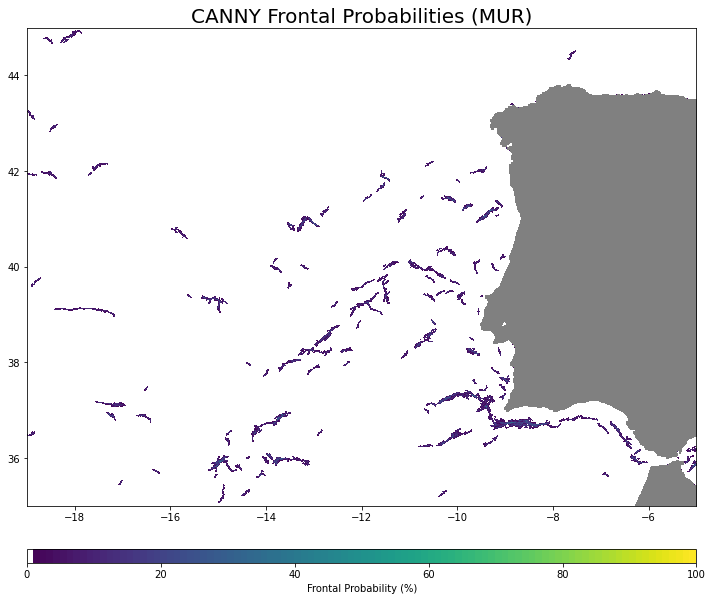

In [23]:
canny_frontal_prob_visualization(xarray_mur, fp_canny=fp_canny, vmin=None, vmax=None)

## ---------------------------------- Belkin O'Reilly Algorithm (BOA)  ------------------------------------------

In [24]:
def BOA_aplication(data_xarray, threshold=0.05):  
    
    """
    Function to, for a given xarray with a longitude, latitude and SST values, 
    identifies fronts through the application of BOA algorithm.
    We also need to define a threshold value to later get the frontal probabilities matrix
    (if the pixel value is greater than the threshold, then it is considered a front, otherwise its not). 
    """
    
    lat = data_xarray['lat'].values
    lon = data_xarray['lon'].values
    ingrid = data_xarray['analysed_sst'].values[0]
    
    front = boa(lon=lon, lat=lat, ingrid=ingrid, nodata = np.nan, direction = False)
    front = np.flip(front, axis=0)
    front = np.array([[front[j][i] for j in range(len(front))] for i in range(len(front[0])-1,-1,-1)])
    
    front = np.where(front>=threshold, 1, front)    
    front = np.where(front<threshold, 0, front)
    
    return front

In [25]:
def frontal_prob_boa(data_xarray, threshold=0.05):
    
    """
    Function applies BOA to several images and returns the matrix of frontal probabilities for certain period.
    The matrices resulting from the application of BOA are summed and divided by the number of periods
    to obtain a front probabilities matrix.
    """
    
    lat_dims = data_xarray.dims['lat']
    lon_dims = data_xarray.dims['lon']
    time_dims = data_xarray.dims['time']
    
    fp = np.zeros((lat_dims,lon_dims)) 
      
        
    for date in data_xarray['time'].values:
        x = data_xarray.sel(time=slice(date, date))
        fp = fp + BOA_aplication(x, threshold=threshold)

    
    fp = fp/(time_dims)*100  #divide FP by the number of periods (time_dims) and multiply by 100 (%)
    
    return fp


In [26]:
def boa_frontal_prob_visualization(data_xarray, fp_boa, vmin=None, vmax=None):
    
    """
    Function to visualize the map of frontal probability.
    vmin and vmax define the data range that the colormap covers -> it helps for visualization purposes.
    """
    base_path = os.getcwd()
    
    #first we apply the frontal_prob function to a certain period of data
    fp = fp_boa.copy()
    
    #Create a mask for our continental zone 
    sst = data_xarray['analysed_sst'].values[0]    #using the first array of the xarray
    mask = np.isnan(np.flipud(sst))    #Boolean array is True where original array (Temp) had Null values
    mask255 =np.where(mask,(np.ones(mask.shape))*255,0).astype("uint8")   #array which pixels = 255 when mask=True
    #Make a dilation to ensure the pixels that belong to the shore are not consideredd fronts
    kernel = np.ones((3,3), np.uint8)
    mask_dilated = cv2.dilate(mask255, kernel)
    
    fp = np.ma.masked_where(mask_dilated==255, fp)
    
    lat_max = data_xarray['lat'].values.max()
    lat_min = data_xarray['lat'].values.min()
    lon_max = data_xarray['lon'].values.max()
    lon_min = data_xarray['lon'].values.min()
    
    
    #Visualization purposes: continenal area in gray, and pixels with value=0 in white   
    viridis = matplotlib.cm.get_cmap('viridis', 100)
    newcolor = viridis(np.linspace(0,1,100))
    white = np.array([1, 1, 1, 1])
    newcolor[0, :] = white
    newcmp = ListedColormap(newcolor)
    newcmp.set_bad(color='gray')

    plt.figure()
    plt.imshow(fp, cmap=newcmp, vmin=vmin, vmax=vmax, extent=[lon_min, lon_max, lat_min, lat_max]) 
    plt.colorbar(orientation='horizontal', fraction=0.025, pad=0.08, aspect=50, label='Frontal Probability (%)')
    plt.title("BOA Frontal Probabilities (MUR)", fontsize=20)
    plt.savefig(os.path.join(base_path, '../data/MUR_seasonal_images/BOA_frontal_prob.jpg'))

In [27]:
boa_f = frontal_prob_boa(xarray_mur, threshold=0.05)

[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s


[########################################] | 100% Completed |  0.1s


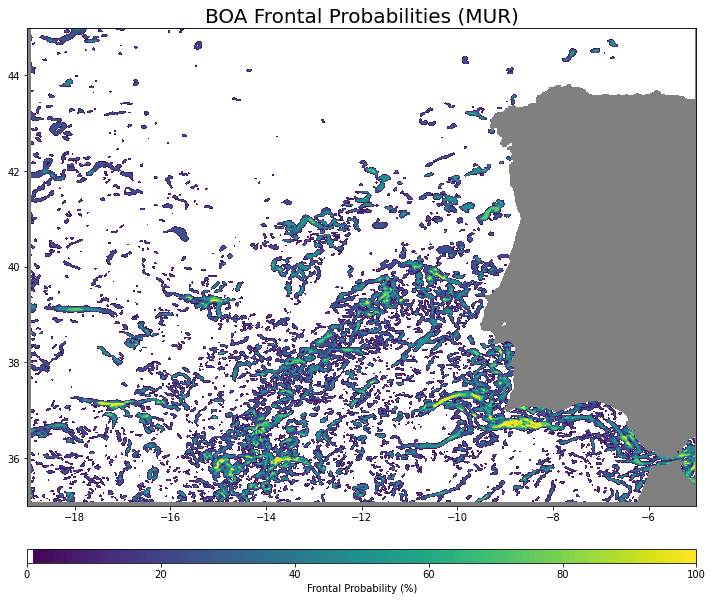

In [28]:
boa_frontal_prob_visualization(xarray_mur, boa_f, vmin=None, vmax=None)

## ---------------------------------- Cayula-Cornillon Algorithm  ------------------------------------------

In [29]:
def front_calc(data_xarray): 
    
    """
    Function that calculates the fronts matrix. Given an xarray (with SST data respective to one day), applies the
    Cayula-Cornillon Algorithm for Single Image Edge Detection (CCA-SIED) to discover the fronts.
    It returns the matrix with the fronts: if pixel = 1 it was considered a front, otherwise, pixel = 0
    It basically converts the (x,y) coordinate points to indexes of the frontal probability matrix. These indexes are considered fronts
    """
    
    
    
    lat_dims = data_xarray.dims['lat']
    lon_dims = data_xarray.dims['lon']
    
    lat_max = data_xarray['lat'].values.max()
    lat_min = data_xarray['lat'].values.min()
    lon_max = data_xarray['lon'].values.max()
    lon_min = data_xarray['lon'].values.min()
    
    div_rows = (lat_max-lat_min)/lat_dims
    div_cols = (lon_max-lon_min)/lon_dims
    
    fp = np.zeros((lat_dims,lon_dims))       #initialize a matrix of zeros
    

    #2 empty arrays that will store the x and y values of the lines that are suposed to be drawn
    x = np.array([])
    y = np.array([])
        
    xdata_final, ydata_final = CCA_SIED(data_xarray)       
    x = np.append(x, xdata_final)
    y = np.append(y, ydata_final)
        
    cols_x = np.array([])
    for value in x:                     
        aux_x = (-lon_min+value)/div_cols                  
        cols_x = np.append(cols_x, aux_x)
    
    rows_y = np.array([])
    for value in y:                    
        aux_y = (lat_max-value)/div_rows            
        rows_y = np.append(rows_y, aux_y)
     
    cols_x = np.round(cols_x)
    rows_y = np.round(rows_y)
            
    for i in range(len(cols_x)):   #it could also be len(rows_y)
        fp[int(rows_y[i]), int(cols_x[i])] = fp[int(rows_y[i]), int(cols_x[i])] + 1
        

            
    fp[fp != 0] = 1
    
    return fp  

In [30]:
def frontal_prob_cca(data_xarray):
    
    """
    Function that allows the visualization of the Frontal Probabilities for the Cayula-Cornillon Algorithm (CCA).
    This function also applies a mask to the frontal probabilities array in order for the continental zone to be 
    well defined.
    """
    
    lat_dims = data_xarray.dims['lat']
    lon_dims = data_xarray.dims['lon']
    
    time_dims = data_xarray.dims['time']
    
    front_prob = np.zeros((lat_dims, lon_dims))   
    
    for date in data_xarray['time'].values:
        x = data_xarray.sel(time=slice(date, date))
        front = front_calc(x)
        front_prob += front
        
    
    front_prob = front_prob/(time_dims)*100   # to get the fp in percentage

    return front_prob
    

In [31]:
def cca_frontal_prob_visualization(data_xarray, fp_cca, vmin=None, vmax=None):
    
    """
    Function to visualize the map of frontal probability.
    vmin and vmax define the data range that the colormap covers -> it helps for visualization purposes.
    """
    base_path = os.getcwd()
    
    #get a copy of the array
    fp = fp_cca.copy()
    
    #Create a mask for our continental zone 
    sst = data_xarray['analysed_sst'].values[0]    #using the first array of the xarray
    mask = np.isnan(np.flipud(sst))    #Boolean array is True where original array (Temp) had Null values
    mask255 =np.where(mask,(np.ones(mask.shape))*255,0).astype("uint8")   #array which pixels = 255 when mask=True
    #Make a dilation to ensure the pixels that belong to the shore are not consideredd fronts
    kernel = np.ones((3,3), np.uint8)
    mask_dilated = cv2.dilate(mask255, kernel)
    
    fp = np.ma.masked_where(mask_dilated==255, fp)
    
    lat_max = data_xarray['lat'].values.max()
    lat_min = data_xarray['lat'].values.min()
    lon_max = data_xarray['lon'].values.max()
    lon_min = data_xarray['lon'].values.min()
    
    
    #Visualization purposes: continenal area in gray, and pixels with value=0 in white   
    viridis = matplotlib.cm.get_cmap('viridis', 100)
    newcolor = viridis(np.linspace(0,1,100))
    white = np.array([1, 1, 1, 1])
    newcolor[0, :] = white
    newcmp = ListedColormap(newcolor)
    newcmp.set_bad(color='gray')

    plt.figure()
    plt.imshow(fp, cmap=newcmp, vmin=vmin, vmax=vmax, extent=[lon_min, lon_max, lat_min, lat_max]) 
    plt.colorbar(orientation='horizontal', fraction=0.025, pad=0.08, aspect=50, label='Frontal Probability (%)')
    plt.title("CCA Frontal Probabilities (MUR)", fontsize=20)
    plt.savefig(os.path.join(base_path, '../data/MUR_seasonal_images/CCA_frontal_prob.jpg'))

[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s


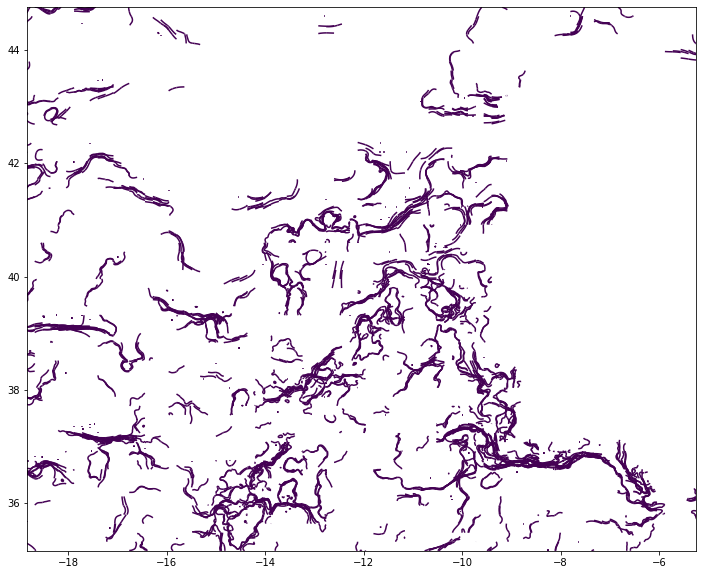

In [32]:
cca_f = frontal_prob_cca(xarray_mur)

[########################################] | 100% Completed |  0.1s


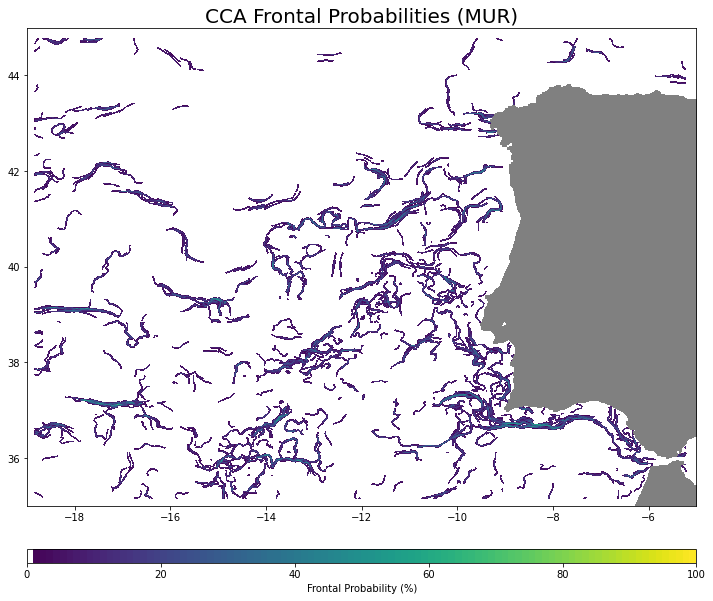

In [34]:
cca_frontal_prob_visualization(xarray_mur, cca_f, vmin=None, vmax=None)